<a href="https://colab.research.google.com/github/khosravym/flexmeter/blob/main/Another_copy_of_FLEXmeter_Demo_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install eemeter
! pip install gridmeter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.0/584.0 KB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import eemeter
import gridmeter
import pandas as pd
import numpy as np


First let's make some load shapes. These will be stand ins for precleaned load shapes.

In [ ]:
meter_data_hourly, temperature_data_hourly, metadata_hourly = \
    eemeter.load_sample('il-electricity-cdd-hdd-hourly')

(<AxesSubplot:ylabel='Energy Use'>, <AxesSubplot:ylabel='Temperature'>)

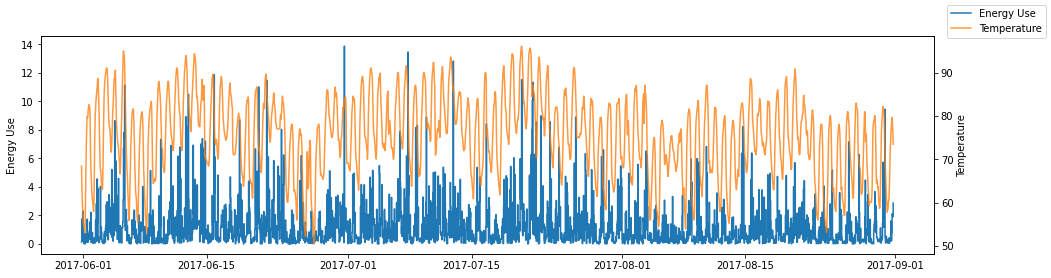

In [ ]:
#trim data to just be summer
start_date = '2017-06-01'
end_date ='2017-09-01'
#put it all in local timezone
meter_data = meter_data_hourly.loc[(meter_data_hourly.index>start_date)& (meter_data_hourly.index<end_date)].tz_convert('US/Central')
temp_data = temperature_data_hourly.loc[(temperature_data_hourly.index>start_date)& (meter_data_hourly.index<end_date)].tz_convert('US/Central')
eemeter.plot_time_series(meter_data, temp_data, figsize=(16, 4))


In [ ]:
#create a data frame of a comparison pool of 100
np.random.default_rng(2021)
comparison_pool = meter_data
for i in range(100):
  #add in random noise
  comparison_pool[i] = comparison_pool.value *np.random.random()*np.sqrt(i)+np.random.normal(0,.2,len(meter_data))

#drop the zeros and the original column
comparison_pool = comparison_pool.drop(comparison_pool.columns[:2],axis=1)
#replace negtive values with 0
comparison_pool[comparison_pool<0] = 0

<ipython-input-6-aef525c60f37>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
#We need to create an event. Let's look at the hottest days
temp_data.sort_values(ascending=False).head()

dt
2017-07-20 16:00:00-05:00    96.07
2017-07-20 15:00:00-05:00    95.67
2017-07-21 15:00:00-05:00    95.66
2017-07-21 16:00:00-05:00    95.41
2017-07-20 17:00:00-05:00    95.40
Name: tempF, dtype: float64

In [ ]:
#let's make the even on 7-20
event = {'start':'2017-07-20 16:00:00','end':'2017-07-20 19:00:00' ,'duration':4}
#blackout the event indices to create the baseline
blackout_event_indices = pd.date_range(start = event['start'], end=event['end'], freq= 'H', tz='US/Central')
#the baseline is 45 days prior and 15 days post event to capture as much information as possible.
baseline_start = pd.to_datetime(event['start']).date()-pd.Timedelta(45, unit='D')
#The baseline end date can also be the event date.
baseline_end = pd.to_datetime(event['start']).date()+pd.Timedelta(15, unit='D')


In [ ]:
#Trim the data to the baseline period
baseline_meter_data = meter_data.loc[(meter_data.index.date>=baseline_start) & (meter_data.index.date<baseline_end)].asfreq('H')
#take the event data and lower usage
baseline_meter_data.loc[baseline_meter_data.index.isin(blackout_event_indices),'value'] = baseline_meter_data.loc[baseline_meter_data.index.isin(blackout_event_indices),'value']*.8
#blackout the event (this can also be the event day)
blackout_meter_data = baseline_meter_data.loc[(~baseline_meter_data.index.isin(blackout_event_indices))].asfreq('H')


In [ ]:
#create the preliminary matrix
preliminary_design_matrix = eemeter.create_caltrack_hourly_preliminary_design_matrix(
    blackout_meter_data, temp_data
)
#segment the hourly model then create the DR model. This follows a standard calTRACK hourly process
#critically here, the segmentation type is single, one model fit over the entire 60 day period
segment_type = 'single'
segmentation = eemeter.segment_time_series(
    preliminary_design_matrix.index,
    segment_type = segment_type
)

occupancy_lookup = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix,
    segmentation=segmentation,
    # threshold=0.65  # default
)
temperature_bins_occ, temperature_bins_unocc  = eemeter.fit_temperature_bins(
    preliminary_design_matrix,
    segmentation=segmentation,
    occupancy_lookup=occupancy_lookup,
    # default_bins=[30, 45, 55, 65, 75, 90],  # default
    # min_temperature_count=20  # default
)
design_matrices = eemeter.create_caltrack_hourly_segmented_design_matrices(
    preliminary_design_matrix,
    segmentation,
    occupancy_lookup,
    temperature_bins_occ,
    temperature_bins_unocc,
)
#fit the model over the entire period
baseline_model = [eemeter.fit_caltrack_hourly_model_segment(segment_name, segment_data)
                    for segment_name, segment_data in design_matrices.items()
                ]

#create the prediction
prediction_segment_type = segment_type
prediction_segment_name_mapping = None
segment_fit = eemeter.SegmentedModel(
     prediction_segment_type=prediction_segment_type,
     prediction_segment_name_mapping=prediction_segment_name_mapping,
     segment_models=baseline_model,
     prediction_feature_processor=eemeter.caltrack_hourly_prediction_feature_processor,
     prediction_feature_processor_kwargs={
      "occupancy_lookup": occupancy_lookup,
      "occupied_temperature_bins": temperature_bins_occ,
      "unoccupied_temperature_bins": temperature_bins_unocc,
       })
#get the counterfactual

#calculate the counterfactual
metered_savings, error_bands = eemeter.metered_savings(
    segment_fit, baseline_meter_data,
    temp_data
)
#get the hourly load shape of the predicted
metered_savings['hour_of_week'] = (metered_savings.index.hour+1) * (metered_savings.index.dayofweek+1)
#don't include the event for a baseline match
meter_load_shape = pd.DataFrame(metered_savings.loc[(~baseline_meter_data.index.isin(blackout_event_indices))].groupby('hour_of_week')['counterfactual_usage'].mean())

In [ ]:
#Do it for comparison group
cf_load_shape = meter_load_shape.copy()
for i in comparison_pool.columns:
  cf_data = comparison_pool[[i]]
  #Trim the data to the baseline period
  baseline_cf_data = cf_data.loc[(cf_data.index.date>=baseline_start) & (cf_data.index.date<baseline_end)].rename({i:'value'},axis=1).asfreq('H')
  #take the event data and raise usage (the counterfactual group will use more during the event)
  baseline_cf_data.loc[baseline_cf_data.index.isin(blackout_event_indices),'value'] = baseline_cf_data.loc[baseline_cf_data.index.isin(blackout_event_indices),'value']*1.2
  #blackout the event (this can also be the event day)
  blackout_cf_data = baseline_cf_data.loc[(~baseline_cf_data.index.isin(blackout_event_indices))].asfreq('H')

  #create the preliminary matrix
  preliminary_design_matrix_cf = eemeter.create_caltrack_hourly_preliminary_design_matrix(
      blackout_cf_data, temp_data
  )
  #segment the hourly model then create the DR model. This follows a standard calTRACK hourly process
  #critically here, the segmentation type is single, one model fit over the entire 60 day period
  segment_type = 'single'
  segmentation_cf = eemeter.segment_time_series(
      preliminary_design_matrix_cf.index,
      segment_type = segment_type
  )

  occupancy_lookup_cf = eemeter.estimate_hour_of_week_occupancy(
      preliminary_design_matrix_cf,
      segmentation=segmentation_cf,
      # threshold=0.65  # default
  )
  temperature_bins_cf_occ, temperature_bins_cf_unocc  = eemeter.fit_temperature_bins(
      preliminary_design_matrix_cf,
      segmentation=segmentation_cf,
      occupancy_lookup=occupancy_lookup_cf,
      # default_bins=[30, 45, 55, 65, 75, 90],  # default
      # min_temperature_count=20  # default
  )
  design_matrices_cf = eemeter.create_caltrack_hourly_segmented_design_matrices(
      preliminary_design_matrix_cf,
      segmentation_cf,
      occupancy_lookup_cf,
      temperature_bins_cf_occ,
      temperature_bins_cf_unocc,
  )
  #fit the model over the entire period
  baseline_model = [eemeter.fit_caltrack_hourly_model_segment(segment_name, segment_data)
                      for segment_name, segment_data in design_matrices_cf.items()
                  ]

  #create the prediction
  prediction_segment_type = segment_type
  prediction_segment_name_mapping = None
  segment_fit = eemeter.SegmentedModel(
      prediction_segment_type=prediction_segment_type,
      prediction_segment_name_mapping=prediction_segment_name_mapping,
      segment_models=baseline_model,
      prediction_feature_processor=eemeter.caltrack_hourly_prediction_feature_processor,
      prediction_feature_processor_kwargs={
        "occupancy_lookup": occupancy_lookup,
        "occupied_temperature_bins": temperature_bins_occ,
        "unoccupied_temperature_bins": temperature_bins_unocc,
        })
  #get the counterfactual

  #calculate the counterfactual
  cf_savings, error_bands = eemeter.metered_savings(
      segment_fit, baseline_cf_data,
      temp_data
  )
  #get the hourly load shape of the predicted counterfactual
  metered_savings = metered_savings.merge(cf_savings,left_index=True, right_index=True, suffixes=('','_'+str(i)+'_'))
  cf_savings['hour_of_week'] = (cf_savings.index.hour+1) * (cf_savings.index.dayofweek+1)
  meter_load_shape[i] = cf_savings.loc[(~baseline_meter_data.index.isin(blackout_event_indices))].groupby('hour_of_week')['counterfactual_usage'].mean()

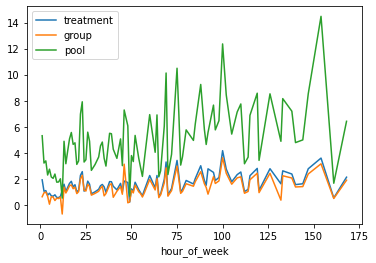

In [ ]:
#select a comparison group
import matplotlib.pyplot as plt
from gridmeter.distance_calc_selection import DistanceMatching
df_treatment_distance = meter_load_shape[['counterfactual_usage']].T
df_pool_distance = meter_load_shape.drop('counterfactual_usage',axis=1).T

df_group_distance_selected = DistanceMatching(
    df_treatment_distance,
    df_pool_distance,
    weights=None,
).get_comparison_group(
    n_matches_per_treatment=4,
)
df_group_distance = df_pool_distance.reindex(df_group_distance_selected.index)

df_treatment_distance.mean().plot(label='treatment')
df_group_distance.mean().plot(label='group')
df_pool_distance.mean().plot(label='pool')
plt.legend()

In [ ]:
#Using the selected comparison group, look at the savings
df_group_distance_selected

,treatment,distance,duplicated
id,,,
27,counterfactual_usage,7.064305,False
83,counterfactual_usage,10.647582,False
28,counterfactual_usage,10.713400,False
54,counterfactual_usage,11.191030,False


In [ ]:
#grab just the matched meters
cols = ['_'+str(i)+'_' for i in df_group_distance_selected.index]
columns = []
for key in cols:
  columns.extend( metered_savings.columns[metered_savings.columns.str.contains(key)])
#

In [ ]:
comparison_results = metered_savings[columns].loc[(metered_savings.index.isin(blackout_event_indices))]
#Average the comparison group savings
comparison_results['reporting_ave'] = comparison_results[comparison_results.columns[comparison_results.columns.str.contains('reporting')]].mean(axis=1)
comparison_results['cf_ave'] = comparison_results[comparison_results.columns[comparison_results.columns.str.contains('counter')]].mean(axis=1)
comparison_results['adj_factor'] = comparison_results['reporting_ave']/comparison_results['cf_ave']


In [ ]:
#use the adjusted counterfactual to calculate adjusted savings
adjusted_savings = metered_savings.loc[(metered_savings.index.isin(blackout_event_indices)),metered_savings.columns[:3]]
adjusted_savings['adj_factor'] = comparison_results['adj_factor']
adjusted_savings['adj_counterfactual'] = adjusted_savings['counterfactual_usage']*adjusted_savings['adj_factor']
adjusted_savings['savings_adj'] =  adjusted_savings['adj_counterfactual']- adjusted_savings['reporting_observed']
adjusted_savings['pct_savings'] = adjusted_savings['savings_adj']/adjusted_savings['adj_counterfactual']
adjusted_savings


,reporting_observed,counterfactual_usage,metered_savings,adj_factor,adj_counterfactual,savings_adj,pct_savings
start,,,,,,,
2017-07-20 16:00:00-05:00,9.200,4.277535,-4.922465,3.251523,13.908503,4.708503,0.338534
2017-07-20 17:00:00-05:00,9.200,4.054875,-5.145125,3.426220,13.892893,4.692893,0.337791
2017-07-20 18:00:00-05:00,0.640,3.793557,3.153557,0.286533,1.086978,0.446978,0.411211
2017-07-20 19:00:00-05:00,0.464,1.948585,1.484585,0.392849,0.765499,0.301499,0.393859
